## OCTAM Data Analysis

In [167]:
# import libraries
import os
import glob
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import plotly.express as px
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import folium
plt.style.use('ggplot')

## Some fuctions before running this analysis 

In [192]:
def shp_to_gdf(shp_path):
    """
    shp_path of shapefile path 
    return gdf read by gpd
    """
    gdf_result = gpd.read_file(shp_path)
    return gdf_result

In [170]:
test_shp = ['data/SR74_BY2019_pm.shp', 'data/SR74_NB2045_gdf.shp', 'data/SR74_BO2045_gdf.shp']
SR74_TOTVOL_pm = shp_to_gdf(test_shp)

## Load Raw Data - OCTAM shapefile

In [117]:
# take two minutes to load
OCTAM_BY19_shp = gpd.read_file('raw_data/OCTAM_Links_19BY.shp')
OCTAM_NB45_shp = gpd.read_file('raw_data/OCTAM_Links_45NB.shp')
OCTAM_BO45_shp = gpd.read_file('raw_data/OCTAM_Links_45BO.shp')

In [251]:
print(list(OCTAM_BY19_shp.columns))

['ID', 'DIR', 'LENGTH', 'FF_OR', 'FF_AD', 'OP_OR', 'OP_AD', 'PK_OR', 'PK_AD', 'CP_OR', 'CP_AD', 'AFARE', 'TL1AM', 'TL1PM', 'TL1OP', 'TL2AM', 'TL2PM', 'TL2OP', 'TL3AM', 'TL3PM', 'TL3OP', 'HOVPK', 'HOVOP', 'WALK', 'WL_TM', 'TR_TM', 'ABFOP', 'BAFOP', 'ABFPK', 'BAFPK', 'FT', 'AT', 'UC', 'AB_LN', 'BA_LN', 'AUX', 'PSL', 'ROADWAY_NA', 'PB_UP', 'AB_COUNT_Y', 'BA_COUNT_Y', 'AB_COUNT_1', 'BA_COUNT_1', 'AB_COUNT_2', 'BA_COUNT_2', 'AB_COUNT_3', 'BA_COUNT_3', 'Y16CNT_FLA', 'AB_COUNT_4', 'BA_COUNT_4', 'TAG_ADT_Y1', 'TAG_ADT_YE', 'PERCENT_ER', 'AB_TAG', 'BA_TAG', 'SCREENLINE', 'HOVPK_19', 'HOVOP_19', 'TL1AM_19', 'TL1PM_19', 'TL1OP_19', 'TL2AM_19', 'TL2PM_19', 'TL2OP_19', 'TL3AM_19', 'TL3PM_19', 'TL3OP_19', 'ML_HOV_COR', 'DIST_OR', 'LABELUNDER', 'ALPHA', 'BETA', 'COUNTY_DES', 'COUNTY', 'A_2000_ORI', 'ANODE_ORIG', 'BNODE_ORIG', 'DIST_ORIG', 'SORT', 'MPAH_FLAG', 'TRUCK_PCT', 'VAL_CNT', 'DO_LVOL', 'AB_COUNT', 'BA_COUNT', 'AB_BASEVOL', 'BA_BASEVOL', 'RSA', 'FF_SPD', 'AB_OPSPD', 'BA_OPSPD', 'AB_PKSPD', 'BA

## OCTAM Data Wrangling

- Extract needed columns from orignal shapefile (**`ID`**, `TOT_COM_LV`, `ROADWAY_NA` (ROADWAY NAME), `geometry`)
- The crs is: `EPSG:4019`


### Save as shapefiles
From gdf **`{year}_TOTVOL_gdf`** to shapefile **`{year}_TOTVOL.shp`**



In [253]:
BY2019_trimmed_gdf = OCTAM_BY19_shp[
    [
        "ID",
        "AB_CAP_DY",
        "AB_COM_LVO",
        "BA_COM_LVO",
        "TOT_COM_LV",
        "AB_COM_LV1",
        "BA_COM_LV1",
        "TOT_COM_L1",
        "AB_COM_LV2",
        "BA_COM_LV2",
        "TOT_COM_L2",
        "ROADWAY_NA",
        "geometry",
    ]
].copy()
NB2045_trimmed_gdf = OCTAM_NB45_shp[
    [
        "ID",
        "AB_CAP_DY",
        "AB_COM_LVO",
        "BA_COM_LVO",
        "TOT_COM_LV",
        "AB_COM_LV1",
        "BA_COM_LV1",
        "TOT_COM_L1",
        "AB_COM_LV2",
        "BA_COM_LV2",
        "TOT_COM_L2",
        "ROADWAY_NA",
        "geometry",
    ]
].copy()
BO2045_trimmed_gdf = OCTAM_BO45_shp[
    [
        "ID",
        "AB_CAP_DY",
        "AB_COM_LVO",
        "BA_COM_LVO",
        "TOT_COM_LV",
        "AB_COM_LV1",
        "BA_COM_LV1",
        "TOT_COM_L1",
        "AB_COM_LV2",
        "BA_COM_LV2",
        "TOT_COM_L2",
        "ROADWAY_NA",
        "geometry",
    ]
].copy()


In [254]:
BY2019_trimmed_gdf = BY2019_trimmed_gdf.rename(
    columns={
        "ID": "ID",
        "AB_CAP_DY": "CAPACITY",
        "AB_COM_LVO": "AB_AMVOL",
        "BA_COM_LVO": "BA_AMVOL",
        "TOT_COM_LV": "TOT_AMVOL",
        "AB_COM_LV1": "AB_PMVOL",
        "BA_COM_LV1": "BA_PMVOL",
        "TOT_COM_L1": "TOT_PMVOL",
        "AB_COM_LV2": "AB_TOTVOL",
        "BA_COM_LV2": "BA_TOTVOL", 
        "TOT_COM_L2": "TOT_VOL",
        "ROADWAY_NA": "RT_NAME",
        "geometry": "geometry",
    }
)

NB2045_trimmed_gdf = NB2045_trimmed_gdf.rename(
    columns={
        "ID": "ID",
        "AB_CAP_DY": "CAPACITY",
        "AB_COM_LVO": "AB_AMVOL",
        "BA_COM_LVO": "BA_AMVOL",
        "TOT_COM_LV": "TOT_AMVOL",
        "AB_COM_LV1": "AB_PMVOL",
        "BA_COM_LV1": "BA_PMVOL",
        "TOT_COM_L1": "TOT_PMVOL",
        "AB_COM_LV2": "AB_TOTVOL",
        "BA_COM_LV2": "BA_TOTVOL", 
        "TOT_COM_L2": "TOT_VOL",
        "ROADWAY_NA": "RT_NAME",
        "geometry": "geometry",
    }
)

BO2045_trimmed_gdf = BO2045_trimmed_gdf.rename(
    columns={
        "ID": "ID",
        "AB_CAP_DY": "CAPACITY",
        "AB_COM_LVO": "AB_AMVOL",
        "BA_COM_LVO": "BA_AMVOL",
        "TOT_COM_LV": "TOT_AMVOL",
        "AB_COM_LV1": "AB_PMVOL",
        "BA_COM_LV1": "BA_PMVOL",
        "TOT_COM_L1": "TOT_PMVOL",
        "AB_COM_LV2": "AB_TOTVOL",
        "BA_COM_LV2": "BA_TOTVOL", 
        "TOT_COM_L2": "TOT_VOL",
        "ROADWAY_NA": "RT_NAME",
        "geometry": "geometry",
    }
)


In [255]:
BY2019_trimmed_gdf[BY2019_trimmed_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,18800.0,822.92919,3167.6963,3990.6255,3679.0363,1028.0877,4707.1241,6191.2727,6188.0182,12379.29,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


In [256]:
BY2019_trimmed_gdf.to_file('data/BY2019_trimmed.shp', driver='ESRI Shapefile')
NB2045_trimmed_gdf.to_file('data/NB2045_trimmed.shp', driver='ESRI Shapefile')
BO2045_trimmed_gdf.to_file('data/BO2045_trimmed.shp', driver='ESRI Shapefile')

## Extract SR 74 BY2019, NB2045, BO2045

In [257]:
SR74_BY2019_gdf = BY2019_trimmed_gdf.loc[BY2019_trimmed_gdf['RT_NAME'].notna()].loc[BY2019_trimmed_gdf['RT_NAME']=='ORTEGA HWY']
SR74_NB2045_gdf = NB2045_trimmed_gdf.loc[NB2045_trimmed_gdf['RT_NAME'].notna()].loc[NB2045_trimmed_gdf['RT_NAME']=='ORTEGA HWY']
SR74_BO2045_gdf = BO2045_trimmed_gdf.loc[BO2045_trimmed_gdf['RT_NAME'].notna()].loc[BO2045_trimmed_gdf['RT_NAME']=='ORTEGA HWY']

In [258]:
SR74_BY2019_gdf.to_file('data/SR74_BY2019_gdf.shp')
SR74_NB2045_gdf.to_file('data/SR74_NB2045_gdf.shp')
SR74_BO2045_gdf.to_file('data/SR74_BO2045_gdf.shp')

<AxesSubplot: >

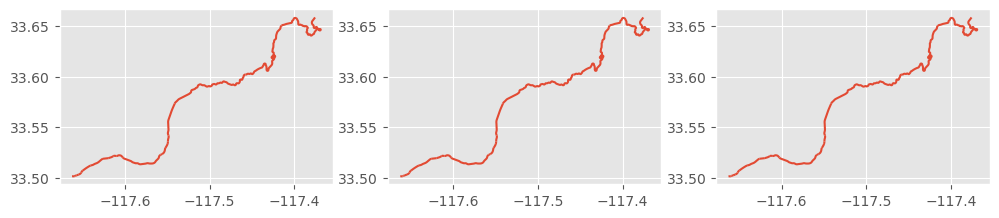

In [259]:
# check SR 74 BY2019 covers the whole SR 74
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 10))
SR74_BY2019_gdf.plot(ax=ax1)
SR74_NB2045_gdf.plot(ax=ax2)
SR74_BO2045_gdf.plot(ax=ax3)

In [263]:
SR74_BY2019_gdf.loc[SR74_BY2019_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,18800.0,822.92919,3167.6963,3990.6255,3679.0363,1028.0877,4707.1241,6191.2727,6188.0182,12379.29,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


In [264]:
SR74_NB2045_gdf.loc[SR74_NB2045_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,18800.0,1595.2318,1983.4526,3578.6845,2168.8833,1669.9583,3838.8416,5480.2168,5620.8773,11101.094,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


In [265]:
SR74_BO2045_gdf.loc[SR74_BO2045_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,37500.0,1910.4627,3936.2529,5846.7156,4615.4026,2217.5099,6832.9126,9102.3414,8884.2576,17986.599,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


## Load Raw Data - Postmile shapefile
### Data Wrangling

1. Extract Needed Columns
- `OBJECTID` 
- `ROUTE`
- `ROUTEID`
- `COUNTY`
- `DISTRICT`
- `PMPREFIX`
- `PM`
- `PMSUFFIX`
- `PMC`
- `ALIGNCODE`
- `Lat_WGS84`
- `Long_WGS84`
2. Conveert to crs `EPSG:4019`
3. Save as new shapefile

In [27]:
postmile_shp = gpd.read_file('raw_data/SHN_Tenth_Postmiles_OC_select.shp')

In [28]:
postmile_shp.head(5)

,OBJECTID,ROUTE,RTESUFFIX,ROUTES,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ODOMETER,PMINTERVAL,HWYSEGMENT,ALIGNCODE,ROUTETYPE,Lat_WGS84,Long_WGS84,CoordWGS84,geometry
0,191,1,NaN,1,1_20171231_L,ORA,12,NaN,9.5,NaN,9.5,5.584000,0.1,Mid Segment,Left,NaN,33.543171,-117.786628,"-117.786627699, 33.5431707614",POINT (-13111947.418 3967624.731)
1,805,1,NaN,1,1_20171231_L,ORA,12,NaN,17.5,NaN,17.5,10.180000,0.1,Mid Segment,Left,NaN,33.612819,-117.891706,"-117.891705828, 33.6128189573",POINT (-13123644.661 3976930.804)
2,991,1,NaN,1,1_20171231_L,ORA,12,NaN,26.5,NaN,26.5,19.190001,0.1,Mid Segment,Left,NaN,33.674212,-118.025442,"-118.025442412, 33.6742115628",POINT (-13138532.150 3985140.039)
3,1127,1,NaN,1,1_20171231_L,ORA,12,NaN,30.6,NaN,30.6,23.290001,0.1,Mid Segment,Left,NaN,33.718914,-118.071566,"-118.071565689, 33.7189143527",POINT (-13143666.570 3991121.250)
4,1602,1,NaN,1,1_20171231_L,ORA,12,NaN,25.5,NaN,25.5,18.190001,0.1,Mid Segment,Left,NaN,33.664521,-118.012269,"-118.012269287, 33.6645208896",POINT (-13137065.724 3983843.842)


In [29]:
postmile_df = postmile_shp[['OBJECTID', 'ROUTE', 'ROUTEID', 'COUNTY', 'DISTRICT', \
                             'PMPREFIX', 'PM', 'PMSUFFIX', 'PMC', 'ALIGNCODE', \
                             'Lat_WGS84', 'Long_WGS84']].copy()

In [30]:
postmile_df.head(5)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84
0,191,1,1_20171231_L,ORA,12,NaN,9.5,NaN,9.5,Left,33.543171,-117.786628
1,805,1,1_20171231_L,ORA,12,NaN,17.5,NaN,17.5,Left,33.612819,-117.891706
2,991,1,1_20171231_L,ORA,12,NaN,26.5,NaN,26.5,Left,33.674212,-118.025442
3,1127,1,1_20171231_L,ORA,12,NaN,30.6,NaN,30.6,Left,33.718914,-118.071566
4,1602,1,1_20171231_L,ORA,12,NaN,25.5,NaN,25.5,Left,33.664521,-118.012269


In [31]:
postmile_df['geometry'] = postmile_df.apply(lambda row: Point(row.Long_WGS84, row.Lat_WGS84), axis=1)

In [32]:
# add geometry column based on lat and long
postmile_gdf = gpd.GeoDataFrame(postmile_df, geometry='geometry')

In [33]:
# set crs
postmile_gdf.crs = 'EPSG:4019'

In [34]:
postmile_gdf.head()

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
0,191,1,1_20171231_L,ORA,12,NaN,9.5,NaN,9.5,Left,33.543171,-117.786628,POINT (-117.78663 33.54317)
1,805,1,1_20171231_L,ORA,12,NaN,17.5,NaN,17.5,Left,33.612819,-117.891706,POINT (-117.89171 33.61282)
2,991,1,1_20171231_L,ORA,12,NaN,26.5,NaN,26.5,Left,33.674212,-118.025442,POINT (-118.02544 33.67421)
3,1127,1,1_20171231_L,ORA,12,NaN,30.6,NaN,30.6,Left,33.718914,-118.071566,POINT (-118.07157 33.71891)
4,1602,1,1_20171231_L,ORA,12,NaN,25.5,NaN,25.5,Left,33.664521,-118.012269,POINT (-118.01227 33.66452)


In [35]:
# save as shapefile
postmile_gdf.to_file('data/postmile_shapefile.shp', driver='ESRI Shapefile')

## Load Cleaned Shapefiles

In [36]:
BY2019_gdf = gpd.read_file('data/BY2019_gdf.shp')
postmile_gdf = gpd.read_file('data/postmile_shapefile.shp')

In [37]:
BY2019_gdf.head(5)

,ID,TOT_VOL,RT_NAME,geometry
0,1,64689.78400,NaN,"LINESTRING (-119.47533 34.38305, -119.47453 34..."
1,2,2831.42750,NaN,"LINESTRING (-119.46459 34.40568, -119.44961 34..."
2,3,352.97207,NaN,"LINESTRING (-119.49493 34.79391, -119.44240 34..."
3,4,798.77784,NaN,"LINESTRING (-119.02344 34.82851, -119.01246 34..."
4,5,56671.68000,NaN,"LINESTRING (-118.88875 34.82567, -118.88213 34..."


In [38]:
postmile_gdf.head(5)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
0,191,1,1_20171231_L,ORA,12,NaN,9.5,NaN,9.5,Left,33.543171,-117.786628,POINT (-117.78663 33.54317)
1,805,1,1_20171231_L,ORA,12,NaN,17.5,NaN,17.5,Left,33.612819,-117.891706,POINT (-117.89171 33.61282)
2,991,1,1_20171231_L,ORA,12,NaN,26.5,NaN,26.5,Left,33.674212,-118.025442,POINT (-118.02544 33.67421)
3,1127,1,1_20171231_L,ORA,12,NaN,30.6,NaN,30.6,Left,33.718914,-118.071566,POINT (-118.07157 33.71891)
4,1602,1,1_20171231_L,ORA,12,NaN,25.5,NaN,25.5,Left,33.664521,-118.012269,POINT (-118.01227 33.66452)


<AxesSubplot: >

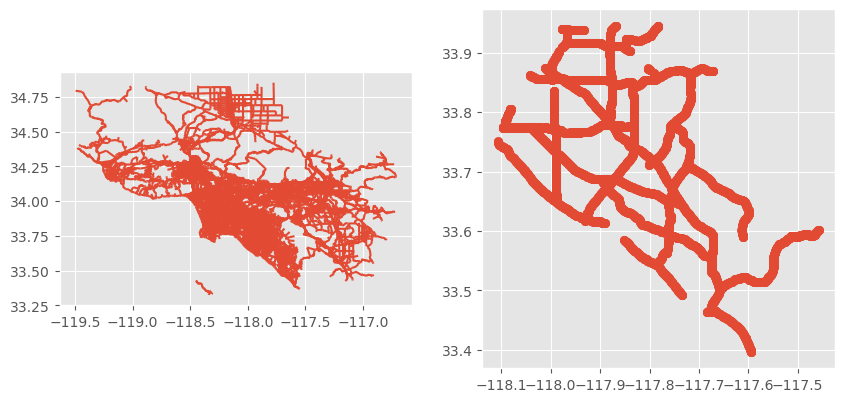

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
BY2019_gdf.plot(ax=ax1)
postmile_gdf.plot(ax=ax2)

## Extract SR 74 postmile and BY 2019

- Check the number of rows are equal for Left and Right
- Export to shapefile

In [58]:
# make sure the number of rows are equal for Left and Right
len(postmile_df.loc[(postmile_gdf['ALIGNCODE']=='Right') & (postmile_gdf['ROUTE']==74)]) == len(postmile_df.loc[(postmile_gdf['ALIGNCODE']=='Left') & (postmile_gdf['ROUTE']==74)])

True

In [40]:
SR74_postmile_gdf = postmile_gdf.loc[(postmile_gdf['ALIGNCODE']=='Right') & (postmile_gdf['ROUTE']==74)]

In [41]:
SR74_postmile_gdf.head(5)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
576,258722,74,74_20171231_R,ORA,12,NaN,11.300000,NaN,11.3,Right,33.580740,-117.529616,POINT (-117.52962 33.58074)
577,258737,74,74_20171231_R,ORA,12,NaN,3.000000,NaN,3,Right,33.521904,-117.613456,POINT (-117.61346 33.52190)
581,259040,74,74_20171231_R,ORA,12,NaN,16.599001,NaN,16.599,Right,33.602202,-117.457767,POINT (-117.45777 33.60220)
584,259362,74,74_20171231_R,ORA,12,NaN,8.800000,NaN,8.8,Right,33.551094,-117.548974,POINT (-117.54897 33.55109)
585,259585,74,74_20171231_R,ORA,12,NaN,11.600000,NaN,11.6,Right,33.582667,-117.525100,POINT (-117.52510 33.58267)


In [42]:
# export the gdf as shapefile
SR74_postmile_gdf.to_file('data/SR74_postmile_gdf.shp')

## Plot shapefiles in folium map before joining

In [ ]:
# plot by matplotlib
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
# BY2019_gdf.plot(ax=ax1)
# postmile_gdf.plot(ax=ax2)

In [44]:
def plot_gdf_with_popups(gdf, attribute):
    center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
    m = folium.Map(location=center, zoom_start=12)
    folium.GeoJson(gdf, name='My Shapefile', \
        tooltip=folium.features.GeoJsonTooltip(fields=[attribute]), \
        style_function=lambda feature: {'color': 'blue','weight': 3}, \
        highlight_function=lambda x: {'weight': 3}).add_to(m)
    return(m)

In [46]:
plot_gdf_with_popups(SR74_postmile_gdf, 'ROUTE')

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]


## Plotting shapefiles in folium map
- [X] create an function to show the maps 

The final cleaned gdfs are `SR74_BY2019_gdf` and `pm_74_gdf`

In [79]:
def plot_gdfs_on_map(gdfs):
    center_lat = 0
    center_lon = 0
    num_points = 0
    for gdf in gdfs:
        center_lat += gdf['geometry'].centroid.y.mean()
        center_lon += gdf['geometry'].centroid.x.mean()
        num_points += len(gdf)
    center_lat /= len(gdfs)
    center_lon /= len(gdfs)
    center = [center_lat, center_lon]
    m = folium.Map(location=center, zoom_start=12)
    for gdf in gdfs:
        folium.GeoJson(gdf).add_to(m)
    return m

In [81]:
sr74_pm_BY2019_gdfs = [SR74_BY2019_gdf, pm_74_gdf]
plot_gdfs_on_map(sr74_pm_BY2019_gdfs)

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat += gdf['geometry'].centroid.y.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon += gdf['geometry'].centroid.x.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat += gdf['geometry'].centroid.y.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/

## Spatial Join Postmile and BY2019

In [269]:
# Load shapefiles of postmile and BY2019
SR74_BY2019_gdf = gpd.read_file('data/SR74_BY2019_gdf.shp')
SR74_NB2045_gdf = gpd.read_file('data/SR74_NB2045_gdf.shp')
SR74_BO2045_gdf = gpd.read_file('data/SR74_BO2045_gdf.shp')
SR74_postmile_gdf = gpd.read_file('data/SR74_postmile_gdf.shp')

In [277]:
SR74_postmile_gdf.head(1)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
0,258722,74,74_20171231_R,ORA,12,NaN,11.3,NaN,11.3,Right,33.58074,-117.529616,POINT (-117.52962 33.58074)


In [270]:
SR74_BO2045_gdf.loc[SR74_BO2045_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
12,20635,37500.0,1910.4627,3936.2529,5846.7156,4615.4026,2217.5099,6832.9126,9102.3414,8884.2576,17986.599,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


In [271]:
SR74_NB2045_gdf.loc[SR74_NB2045_gdf['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
12,20635,18800.0,1595.2318,1983.4526,3578.6845,2168.8833,1669.9583,3838.8416,5480.2168,5620.8773,11101.094,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


In [272]:
SR74_BY2019_pm = gpd.sjoin_nearest(SR74_postmile_gdf, SR74_BY2019_gdf, how='inner', distance_col='distance')
SR74_NB2045_pm = gpd.sjoin_nearest(SR74_postmile_gdf, SR74_NB2045_gdf, how='inner', distance_col='distance')
SR74_BO2045_pm = gpd.sjoin_nearest(SR74_postmile_gdf, SR74_BO2045_gdf, how='inner', distance_col='distance')

/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [273]:
plot_gdf_with_popups(SR74_BY2019_pm, 'TOT_VOL')

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]


In [154]:
plot_gdf_with_popups(SR74_NB2045_pm, 'TOT_VOL')
plot_gdf_with_popups(SR74_BO2045_pm, 'TOT_VOL')
plot_gdf_with_popups(SR74_BY2019_pm, 'TOT_VOL')

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]


In [276]:
print(list(SR74_NB2045_pm.columns))
SR74_NB2045_pm['index_right']

['OBJECTID', 'ROUTE', 'ROUTEID', 'COUNTY', 'DISTRICT', 'PMPREFIX', 'PM', 'PMSUFFIX', 'PMC', 'ALIGNCODE', 'Lat_WGS84', 'Long_WGS84', 'geometry', 'index_right', 'ID', 'CAPACITY', 'AB_AMVOL', 'BA_AMVOL', 'TOT_AMVOL', 'AB_PMVOL', 'BA_PMVOL', 'TOT_PMVOL', 'AB_TOTVOL', 'BA_TOTVOL', 'TOT_VOL', 'RT_NAME', 'distance']


0      12
4      12
7      12
11     12
14     12
       ..
126     6
130     6
144     6
151     6
165     6
Name: index_right, Length: 170, dtype: int64

In [293]:
SR74_BY2019_pm = SR74_BY2019_pm[
    [
        "ID",
        "OBJECTID",
        "ROUTE",
        "ROUTEID",
        "COUNTY",
        "DISTRICT",
        "PMPREFIX",
        "PM",
        "PMSUFFIX",
        "PMC",
        "CAPACITY",
        "AB_AMVOL",
        "BA_AMVOL",
        "TOT_AMVOL",
        "AB_PMVOL",
        "BA_PMVOL",
        "TOT_PMVOL",
        "AB_TOTVOL",
        "BA_TOTVOL",
        "TOT_VOL",
        "Lat_WGS84",
        "Long_WGS84",
        "geometry",
    ]
].copy()
SR74_NB2045_pm = SR74_NB2045_pm[
    [
        "ID",
        "OBJECTID",
        "ROUTE",
        "ROUTEID",
        "COUNTY",
        "DISTRICT",
        "PMPREFIX",
        "PM",
        "PMSUFFIX",
        "PMC",
        "CAPACITY",
        "AB_AMVOL",
        "BA_AMVOL",
        "TOT_AMVOL",
        "AB_PMVOL",
        "BA_PMVOL",
        "TOT_PMVOL",
        "AB_TOTVOL",
        "BA_TOTVOL",
        "TOT_VOL",
        "Lat_WGS84",
        "Long_WGS84",
        "geometry",
    ]
].copy()
SR74_BO2045_pm = SR74_BO2045_pm[
    [
        "ID",
        "OBJECTID",
        "ROUTE",
        "ROUTEID",
        "COUNTY",
        "DISTRICT",
        "PMPREFIX",
        "PM",
        "PMSUFFIX",
        "PMC",
        "CAPACITY",
        "AB_AMVOL",
        "BA_AMVOL",
        "TOT_AMVOL",
        "AB_PMVOL",
        "BA_PMVOL",
        "TOT_PMVOL",
        "AB_TOTVOL",
        "BA_TOTVOL",
        "TOT_VOL",
        "Lat_WGS84",
        "Long_WGS84",
        "geometry",
    ]
].copy()


In [294]:
SR74_BY2019_pm = SR74_BY2019_pm.sort_values('PM', ascending=True).copy()
SR74_NB2045_pm = SR74_NB2045_pm.sort_values('PM', ascending=True).copy()
SR74_BO2045_pm = SR74_BO2045_pm.sort_values('PM', ascending=True).copy()

In [295]:
SR74_BY2019_pm.to_file('data/SR74_BY2019_pm.shp')
SR74_NB2045_pm.to_file('data/SR74_NB2045_pm.shp')
SR74_BO2045_pm.to_file('data/SR74_BO2045_pm.shp')

## Read joined shapefile

In [296]:
SR74_BY2019_pm = gpd.read_file('data/SR74_BY2019_pm.shp')
SR74_NB2045_pm = gpd.read_file('data/SR74_NB2045_pm.shp')
SR74_BO2045_pm = gpd.read_file('data/SR74_BO2045_pm.shp')

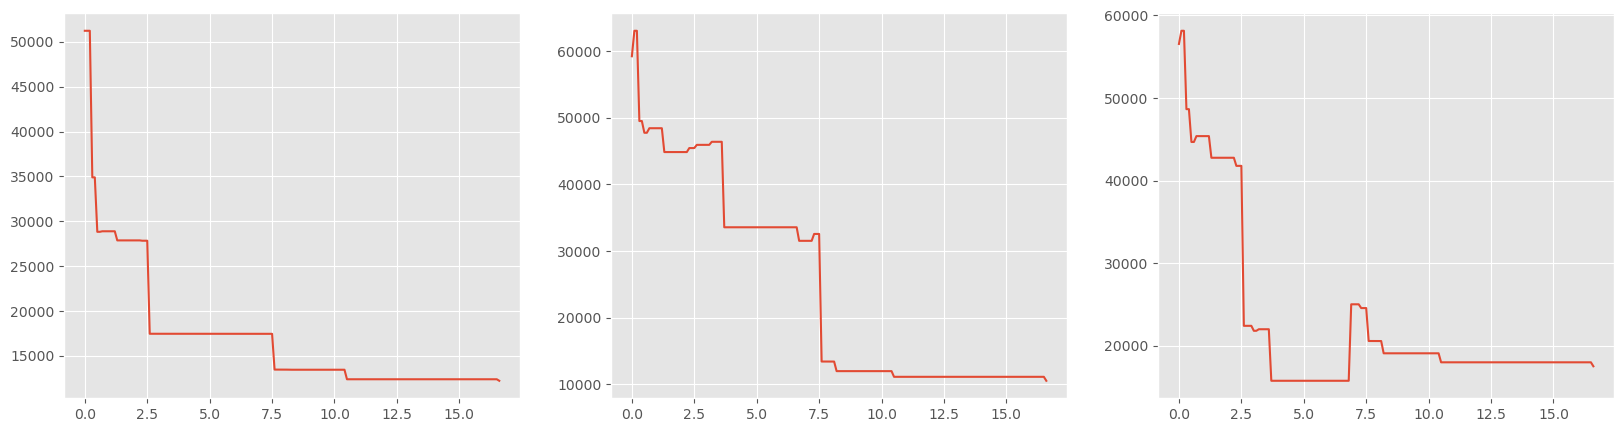

In [281]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
ax1.plot(SR74_BY2019_pm['PM'], SR74_BY2019_pm['TOT_VOL'])
ax2.plot(SR74_NB2045_pm['PM'], SR74_NB2045_pm['TOT_VOL'])
ax3.plot(SR74_BO2045_pm['PM'], SR74_BO2045_pm['TOT_VOL'])

Text(0, 0.5, 'Traffic Volume')

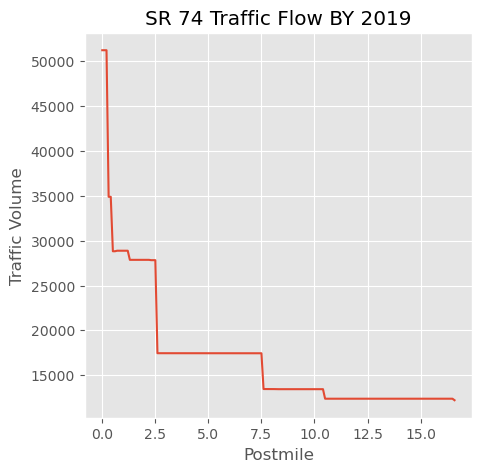

In [184]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(sr74_BY2019_gdf['PM'], sr74_BY2019_gdf['TOT_VOL'])
ax.set_title("SR 74 Traffic Flow BY 2019")
ax.set_xlabel("Postmile")
ax.set_ylabel("Traffic Volume")

## Traffic Data Analysis

#### Sections 
1. PM 0.00 - 2.60
2. PM 2.60 - 7.20
3. PM 7.20 - 16.60


In [297]:
def cmcp_section(pm):
    if pm <=2.6:
        return 1
    elif 2.6 < pm <= 7.2:
        return 2
    else:
            return 3

In [298]:
SR74_BY2019_pm['SECTION'] = np.vectorize(cmcp_section)(SR74_BY2019_pm['PM'])

In [299]:
# combine all 
SR74_BY2019_pm.columns

Index(['ID', 'OBJECTID', 'ROUTE', 'ROUTEID', 'COUNTY', 'DISTRICT', 'PMPREFIX',
       'PM', 'PMSUFFIX', 'PMC', 'CAPACITY', 'AB_AMVOL', 'BA_AMVOL',
       'TOT_AMVOL', 'AB_PMVOL', 'BA_PMVOL', 'TOT_PMVOL', 'AB_TOTVOL',
       'BA_TOTVOL', 'TOT_VOL', 'Lat_WGS84', 'Long_WGS84', 'geometry',
       'SECTION'],
      dtype='object')

In [300]:
SR74_all_pm = SR74_BY2019_pm[
    [
        "ID",
        "OBJECTID",
        "ROUTE",
        "PMPREFIX",
        "PM",
        "PMC",
        "SECTION",
        "CAPACITY",
        "AB_AMVOL",
        "BA_AMVOL",
        "TOT_AMVOL",
        "AB_PMVOL",
        "BA_PMVOL",
        "TOT_PMVOL",
        "AB_TOTVOL",
        "BA_TOTVOL",
        "TOT_VOL",
        "Lat_WGS84",
        "Long_WGS84",
        "geometry",
    ]
].copy()


In [301]:
SR74_all_pm = SR74_all_pm.rename(
    columns={
        "AB_AMVOL": "BY2019_AB_AMVOL",
        "BA_AMVOL": "BY2019_BA_AMVOL",
        "TOT_AMVOL": "BY2019_TOT_AMVOL",
        "AB_PMVOL": "BY2019_AB_PMVOL",
        "BA_PMVOL": "BY2019_BA_PMVOL",
        "TOT_PMVOL": "BY2019_TOT_PMVOL",
        "AB_TOTVOL": "BY2019_AB_TOTVOL",
        "BA_TOTVOL": "BY2019_BA_TOTVOL",
        "TOT_VOL": "BY2019_TOTVOL",
    }
)


In [302]:
SR74_all_pm.columns

Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'CAPACITY', 'BY2019_AB_AMVOL', 'BY2019_BA_AMVOL', 'BY2019_TOT_AMVOL',
       'BY2019_AB_PMVOL', 'BY2019_BA_PMVOL', 'BY2019_TOT_PMVOL',
       'BY2019_AB_TOTVOL', 'BY2019_BA_TOTVOL', 'BY2019_TOTVOL', 'Lat_WGS84',
       'Long_WGS84', 'geometry'],
      dtype='object')

In [303]:
SR74_all_pm = SR74_all_pm.merge(
    SR74_BO2045_pm[
        [
            "OBJECTID",
            "AB_AMVOL",
            "BA_AMVOL",
            "TOT_AMVOL",
            "AB_PMVOL",
            "BA_PMVOL",
            "TOT_PMVOL",
            "AB_TOTVOL",
            "BA_TOTVOL",
            "TOT_VOL",
        ]
    ],
    on="OBJECTID",
    how="inner",
)

In [304]:
SR74_all_pm.columns

Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'CAPACITY', 'BY2019_AB_AMVOL', 'BY2019_BA_AMVOL', 'BY2019_TOT_AMVOL',
       'BY2019_AB_PMVOL', 'BY2019_BA_PMVOL', 'BY2019_TOT_PMVOL',
       'BY2019_AB_TOTVOL', 'BY2019_BA_TOTVOL', 'BY2019_TOTVOL', 'Lat_WGS84',
       'Long_WGS84', 'geometry', 'AB_AMVOL', 'BA_AMVOL', 'TOT_AMVOL',
       'AB_PMVOL', 'BA_PMVOL', 'TOT_PMVOL', 'AB_TOTVOL', 'BA_TOTVOL',
       'TOT_VOL'],
      dtype='object')

In [305]:
SR74_all_pm = SR74_all_pm.rename(
    columns={
        "AB_AMVOL": "BO2045_AB_AMVOL",
        "BA_AMVOL": "BO2045_BA_AMVOL",
        "TOT_AMVOL": "BO2045_TOT_AMVOL",
        "AB_PMVOL": "BO2045_AB_PMVOL",
        "BA_PMVOL": "BO2045_BA_PMVOL",
        "TOT_PMVOL": "BO2045_TOT_PMVOL",
        "AB_TOTVOL": "BO2045_AB_TOTVOL",
        "BA_TOTVOL": "BO2045_BA_TOTVOL",
        "TOT_VOL": "BO2045_TOTVOL",
    }
)

In [307]:
SR74_all_pm = SR74_all_pm.merge(
    SR74_NB2045_pm[
        [
            "OBJECTID",
            "AB_AMVOL",
            "BA_AMVOL",
            "TOT_AMVOL",
            "AB_PMVOL",
            "BA_PMVOL",
            "TOT_PMVOL",
            "AB_TOTVOL",
            "BA_TOTVOL",
            "TOT_VOL",
        ]
    ],
    on="OBJECTID",
    how="inner",
)

In [308]:
SR74_all_pm = SR74_all_pm.rename(
    columns={
        "AB_AMVOL": "NB2045_AB_AMVOL",
        "BA_AMVOL": "NB2045_BA_AMVOL",
        "TOT_AMVOL": "NB2045_TOT_AMVOL",
        "AB_PMVOL": "NB2045_AB_PMVOL",
        "BA_PMVOL": "NB2045_BA_PMVOL",
        "TOT_PMVOL": "NB2045_TOT_PMVOL",
        "AB_TOTVOL": "NB2045_AB_TOTVOL",
        "BA_TOTVOL": "NB2045_BA_TOTVOL",
        "TOT_VOL": "NB2045_TOTVOL",
    }
)

In [309]:
print(list(SR74_all_pm.columns))

['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION', 'CAPACITY', 'BY2019_AB_AMVOL', 'BY2019_BA_AMVOL', 'BY2019_TOT_AMVOL', 'BY2019_AB_PMVOL', 'BY2019_BA_PMVOL', 'BY2019_TOT_PMVOL', 'BY2019_AB_TOTVOL', 'BY2019_BA_TOTVOL', 'BY2019_TOTVOL', 'Lat_WGS84', 'Long_WGS84', 'geometry', 'BO2045_AB_AMVOL', 'BO2045_BA_AMVOL', 'BO2045_TOT_AMVOL', 'BO2045_AB_PMVOL', 'BO2045_BA_PMVOL', 'BO2045_TOT_PMVOL', 'BO2045_AB_TOTVOL', 'BO2045_BA_TOTVOL', 'BO2045_TOTVOL', 'NB2045_AB_AMVOL', 'NB2045_BA_AMVOL', 'NB2045_TOT_AMVOL', 'NB2045_AB_PMVOL', 'NB2045_BA_PMVOL', 'NB2045_TOT_PMVOL', 'NB2045_AB_TOTVOL', 'NB2045_BA_TOTVOL', 'NB2045_TOTVOL']


In [314]:
# shapefile has limits on the length of column name

# SR74_all_pm.to_file('data/SR74_all_pm.shp', driver='ESRI Shapefile')

In [ ]:
# save to parquet (requires pyarrow library)
SR74_all_pm.to_parquet('data/SR74_all_pm.parquet')

In [315]:
SR74_all_pm = pd.read_parquet('data/SR74_all_pm.parquet')

In [316]:
# section AADT
SR74_all_pm[['SECTION', 'BY2019_TOTVOL', 'NB2045_TOTVOL', 'BO2045_TOTVOL']].groupby(['SECTION']).mean()

,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL
SECTION,,,
1,30681.239069,47975.772483,44573.711379
2,17453.825229,36452.169313,18117.598083
3,12873.118484,12146.116495,18629.396495


In [324]:
# AM Peak Total Peak
SR74_all_pm[['SECTION', 'BY2019_TOT_AMVOL', 'NB2045_TOT_AMVOL', 'BO2045_TOT_AMVOL']].groupby(['SECTION']).mean()

,BY2019_TOT_AMVOL,NB2045_TOT_AMVOL,BO2045_TOT_AMVOL
SECTION,,,
1,6754.839690,9160.997962,9773.801507
2,5626.690596,9928.709617,6289.939392
3,4151.667534,3854.153190,6041.373348


In [323]:
# PM Peak Total 
SR74_all_pm[['SECTION', 'BY2019_TOT_PMVOL', 'NB2045_TOT_PMVOL', 'BO2045_TOT_PMVOL']].groupby(['SECTION']).mean()

,BY2019_TOT_PMVOL,NB2045_TOT_PMVOL,BO2045_TOT_PMVOL
SECTION,,,
1,9542.310769,12344.717931,13474.681717
2,6607.092310,12575.539708,6872.954937
3,4892.867425,4196.115139,7073.850003


In [325]:
# AM Peak AB
SR74_all_pm[['SECTION', 'BY2019_AB_AMVOL', 'NB2045_AB_AMVOL', 'BO2045_AB_AMVOL']].groupby(['SECTION']).mean()

,BY2019_AB_AMVOL,NB2045_AB_AMVOL,BO2045_AB_AMVOL
SECTION,,,
1,2870.268217,4129.485397,4373.748400
2,3703.002773,6011.494031,4083.247252
3,1512.922579,1795.851502,2544.551835


In [326]:
# AM Peak BA
SR74_all_pm[['SECTION', 'BY2019_BA_AMVOL', 'NB2045_BA_AMVOL', 'BO2045_BA_AMVOL']].groupby(['SECTION']).mean()

,BY2019_BA_AMVOL,NB2045_BA_AMVOL,BO2045_BA_AMVOL
SECTION,,,
1,3884.571517,5031.512531,5400.053259
2,1923.687806,3917.215667,2206.692110
3,2638.744951,2058.301617,3496.821509


In [327]:
# PM Peak AB
SR74_all_pm[['SECTION', 'BY2019_AB_PMVOL', 'NB2045_AB_PMVOL', 'BO2045_AB_PMVOL']].groupby(['SECTION']).mean()

,BY2019_AB_PMVOL,NB2045_AB_PMVOL,BO2045_AB_PMVOL
SECTION,,,
1,5167.632803,6418.467203,6948.900621
2,2297.528706,5291.559310,2684.469483
3,3083.736439,2252.914515,4102.474356


In [328]:
# PM Peak BA
SR74_all_pm[['SECTION', 'BY2019_BA_PMVOL', 'NB2045_BA_PMVOL', 'BO2045_BA_PMVOL']].groupby(['SECTION']).mean()

,BY2019_BA_PMVOL,NB2045_BA_PMVOL,BO2045_BA_PMVOL
SECTION,,,
1,4374.678048,5926.250817,6525.781372
2,4309.563600,7283.980677,4188.485354
3,1809.130913,1943.200596,2971.375581
